This notebook studies the differences in the evolution between the autonomous and non-autonomous systems. Specifically, the evolution is first simulated according to the standard model for a time given by t_max. Then, the evolution continues from t_max up to t_max_2 weeks, but in this second period the system is evolved in parallel, following both the original equations and those with the damage term removed. The two trajectories are then plotted for comparison. Meanwhile, a study is conducted to assess the relevance of the damage term compared to the other terms in the evolution equations for N and D. Plots showing their evolution over time are displayed

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import configparser
import pandas as pd
import os
import math

### One-step update in the system's evolution
Both the autonomous and non-autonomous systems are implemented.

In [5]:
#Non autonomous
def one_step(t, dt, dx, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, H_i, C_i, M_i, par, diffusion, boundary):

    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = par
    D_H, D_C, D_M = diffusion

    for i in range(len(H)):

        ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new, boundary)
        ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new, boundary)
        ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new, boundary)
        ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new)
        ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new)
        ev_R(i, dt, d_D, k4, k6, M, D, R, R_new)

#Autonomous
def one_step_autonomous(dt, dx, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, H_i, C_i, M_i, par, diffusion, boundary):

    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = par
    D_H, D_C, D_M = diffusion

    for i in range(len(H)):

        ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new, boundary)
        ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new, boundary)
        ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new, boundary)
        ev_N_autonomous(i, dt, k4, k5, R, C, N, N_new)
        ev_D_autonomous(i, dt, d_D, k5, k6, C, M, N, D, D_new)
        ev_R(i, dt, d_D, k4, k6, M, D, R, R_new)

### Damage function

In [6]:
def damage(t, sigma, m, h):

    if t==0 or t <=1e-14:
        return 0.
    else:
       return h / (t * sigma * np.sqrt(2*np.pi)) * np.exp(-(np.log(t) - m)**2 / (2. * sigma**2))

### Diffusion functions

In [7]:
def diff_H(i, dx, D_H, H, precision=14):
    if i == 0:
        diff = H[i+1] - H[i]
    elif i == len(H) - 1:
        diff = H[i-1] - H[i]
    else:
        diff = H[i+1] + H[i-1] - 2 * H[i]
    
#Round the relative difference to avoid small floating-point errors
    if round(diff / (abs(H[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_H / dx * diff

def diff_C(i, dx, D_C, C, precision=14):
    if i == 0:
        diff = C[i+1] - C[i]
    elif i == len(C) - 1:
        diff = C[i-1] - C[i]
    else:
        diff = C[i+1] + C[i-1] - 2 * C[i]
    
    if round(diff / (abs(C[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_C / dx * diff

def diff_M(i, dx, D_M, M, precision=14):
    if i == 0:
        diff = M[i+1] - M[i]
    elif i == len(M) - 1:
        diff = M[i-1] - M[i]
    else:
        diff = M[i+1] + M[i-1] - 2 * M[i]
    
    if round(diff / (abs(M[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_M / dx * diff

### Evolution of the immune cells
Possible boundary conditions:
- periodic
- evolving_sym: the rightmost and leftmost cells are initialized in the same way and evolve like the inner ones
- evolving_asym: the rightmost and leftmost cells are initialized differently and evolve like the inner ones
- fixed_sym: he rightmost and leftmost cells are initialized in the same way and cannot evolve
- fixed_asym: the rightmost and leftmost cells are initialised differently and cannot evolve

In [8]:
def ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new, boundary):
    
    if boundary in ['evolving_sym', 'evolving_asym']:
        H_new[i] = H[i] + dt * (diff_H(i, dx, D_H, H) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
    elif boundary in ['fixed_sym', 'fixed_asym']:
        if i==0 or i==len(H)-1:
            H_new[i] = H[i]
        else:
            H_new[i] = H[i] + dt * (diff_H(i, dx, D_H, H) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
    elif boundary=='periodic':
        if i==0:
            H_new[i] = H[i] + dt * (D_H / dx * (H[i+1] + H[len(H)-1] - 2*H[i]) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
        elif i==len(H)-1:
            H_new[i] = H[i] + dt * (D_H / dx * (H[0] + H[i-1] - 2*H[i]) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
        else:
            H_new[i] = H[i] + dt * (D_H / dx * (H[i+1] + H[i-1] - 2*H[i]) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
    else:
        print('Cannot perform computation without some specified boundary conditions')

def ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new, boundary):
    
    if boundary in ['evolving_sym', 'evolving_asym']:
        C_new[i] = C[i] + dt * (diff_C(i, dx, D_C, C) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
    elif boundary in ['fixed_sym', 'fixed_asym']:
        if i==0 or i==len(C)-1:
            C_new[i] = C[i]
        else:
            C_new[i] = C[i] + dt * (diff_C(i, dx, D_C, C) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
    elif boundary=='periodic':
        if i==0:
            C_new[i] = C[i] + dt * (D_C / dx * (C[i+1] + C[len(C)-1] - 2*C[i]) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
        elif i==N_cells-1:
            C_new[i] = C[i] + dt * (D_C / dx * (C[0] + C[i-1] - 2*C[i]) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
        else:
            C_new[i] = C[i] + dt * (D_C / dx * (C[i+1] + C[i-1] - 2*C[i]) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
    else:
        print('Cannot perform computation without some specified boundary conditions')
   
def ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new, boundary):
    
    if boundary in ['evolving_sym', 'evolving_asym']:
        M_new[i] = M[i] + dt * (diff_M(i, dx, D_M, M) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
    elif boundary in ['fixed_sym', 'fixed_asym']:
        if i==0 or i==len(M)-1:
            M_new[i] = M[i]
        else:
            M_new[i] = M[i] + dt * (diff_M(i, dx, D_M, M) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
    elif boundary=='periodic':
        if i==0:
            M_new[i] = M[i] + dt * (D_M / dx * (M[i+1] + M[len(M)-1] - 2*M[i]) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
        elif i==len(M)-1:
            M_new[i] = M[i] + dt * (D_M / dx * (M[0] + M[i-1] - 2*M[i]) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
        else:
            M_new[i] = M[i] + dt * (D_M / dx * (M[i+1] + M[i-1] - 2*M[i]) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
    else:
        print('Cannot perform computation without some specified boundary conditions')
            

### Evolution of the composition of muscle tissue

To quantify how relevant the damage term is in the evolution, its value at each time step is stored, along with the values of the other terms present in the equations where it appears. This will allow us to observe when the damage becomes negligible. Note that for each simulation, the following cell needs to be rerun; otherwise, the values from the new simulation will simply be appended to the lists created and filled in the previous simulation.

In [9]:
#Lists to store the values taken at each time step by the terms in the evolution expressions of N and D
Normal = []
Damaged = []
dt_k4_R = []
dt_k5_C_N = []
dt_N_damage = []
dt_k6_D_M = []
dt_dD_D = []
dam = []

def ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new):
    N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * (k5 * C[i] + damage(t, sigma, m, h)))
    if i==0:
        dam.append(damage(t, sigma, m, h))
        Normal.append(N[i])
        dt_k4_R.append(dt * k4 * R[i])
        dt_k5_C_N.append(dt * N[i] * k5 * C[i])
        dt_N_damage.append(dt * N[i] * damage(t, sigma, m, h))
def ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new):
    D_new[i] = D[i] + dt * (N[i] * (k5 * C[i] + damage(t, sigma, m, h)) - D[i] * (k6 * M[i] + d_D))
    if i==0:
        Damaged.append(D[i])
        dt_k6_D_M.append(dt * D[i] * k6 * M[i])
        dt_dD_D. append(dt *  D[i] * d_D)

def ev_N_autonomous(i, dt, k4, k5, R, C, N, N_new):
    N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * k5 * C[i])
        
def ev_D_autonomous(i, dt, d_D, k5, k6, C, M, N, D, D_new):
    D_new[i] = D[i] + dt * (N[i] * k5 * C[i] - D[i] * (k6 * M[i] + d_D))
        
def ev_R(i, dt, d_D, k4, k6, M, D, R, R_new):
    R_new[i] = R[i] + dt * (D[i] * (k6 * M[i] + d_D) - k4 * R[i])

### Save the output to a .csv file

In [10]:
def save_to_csv(output_list, column_name, directory, file_name):
    os.makedirs(directory, exist_ok=True)
    
    file_path = os.path.join(directory, file_name)
    
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        df = pd.DataFrame()

    df[column_name] = output_list
    
    df.to_csv(file_path, index=False)

### Function to retrieve information from the configuration file

In [11]:
def extract_values(section_name, config):
    values = []
    if section_name in config:
        for key, value in config[section_name].items():
            values.append(float(value))
    else:
        print(f'Section "{section_name}" is not in the configuration file')
    return values

### Simulation

Names with '_a' refer to the autonomous system.

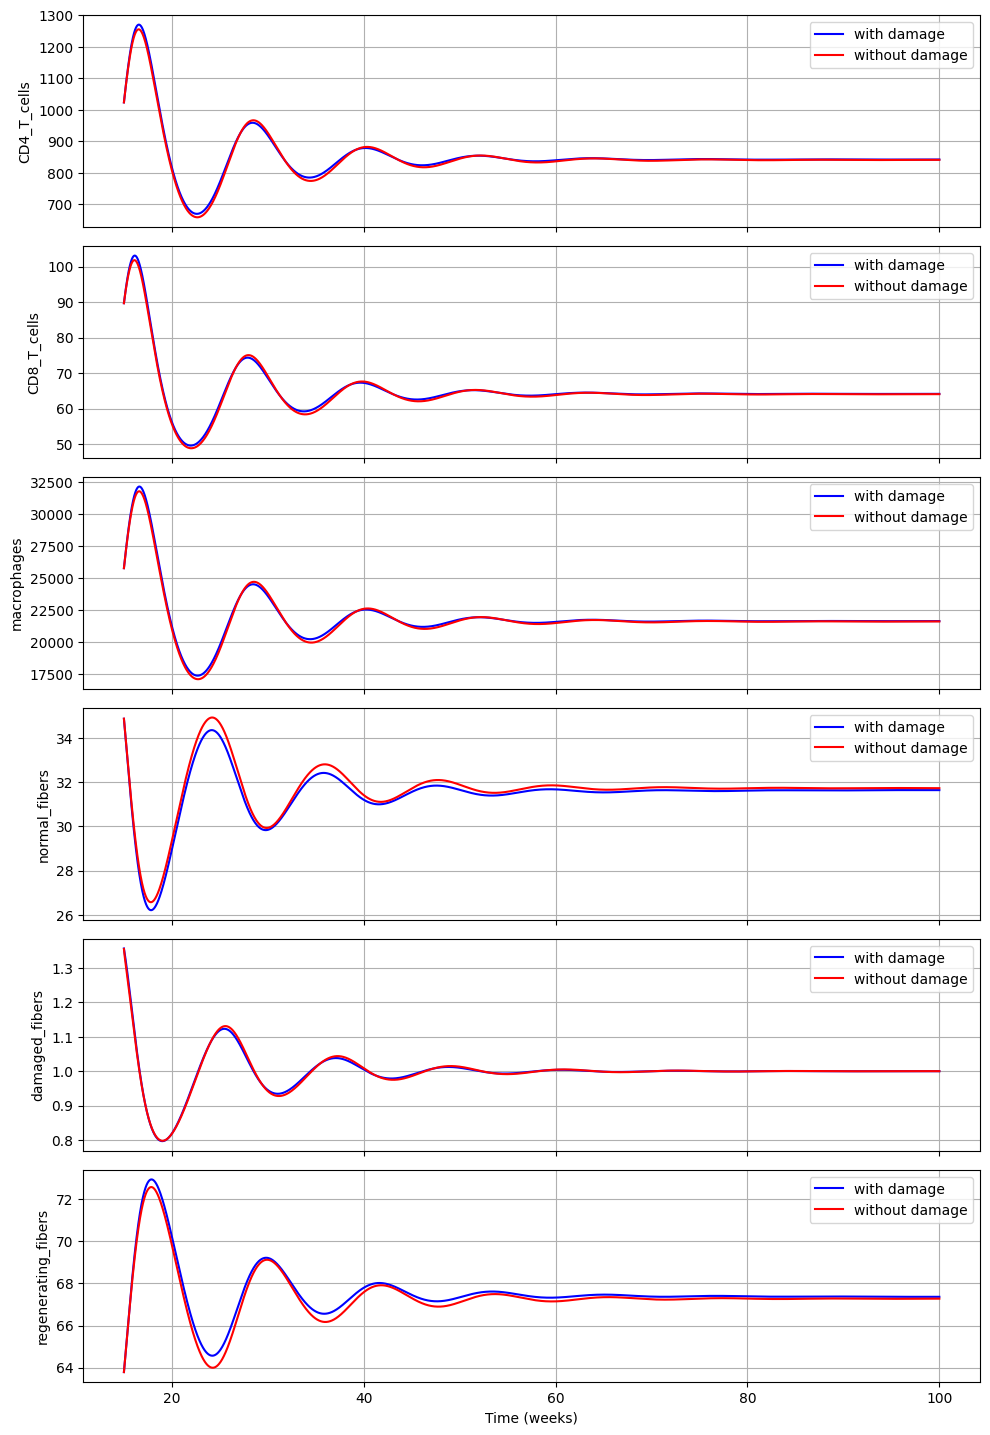

In [12]:
#Extract the needed parameters from the configuration file
config = configparser.ConfigParser()
config.read('config.ini')

#Parameters
i_c = extract_values('initial_conditions_sx', config)
par = extract_values('parameters', config)
sim = extract_values('simulation_par', config)
dt, t_min, t_max, dx, N_cells = sim
N_cells = int(N_cells)

#Since we are studying the homogeneous scenario, the diffusion coefficients and boundary conditions are set as follows
diffusion = [0., 0., 0.]
boundary = 'periodic'

#Number of weeks at which the second evolution ends
t_max_2 = 100

#List of N_cells values for each state variable
H, C, M, N, D, R = [[i_c[i]] * N_cells for i in range(6)]
#List of N_cells values to store the uniform initial conditions
H_i, C_i, M_i, N_i, D_i, R_i = [[i_c[i]] * N_cells for i in range(6)]
#List of N_cells values for each state variable to store the evolution at each time step
H_new, C_new, M_new, N_new, D_new, R_new = [[i_c[i]] * N_cells for i in range(6)]

#List of N_cells values for each state variable, used to store the evolution at each time step.
H_values = []
C_values = []
M_values = []
N_values = []
D_values = []
R_values = []

H_a_values = []
C_a_values = []
M_a_values = []
N_a_values = []
D_a_values = []
R_a_values = []

#Array to store the time steps of the evolution from t_min to t_max_2
t = [t_min]

#Maximum step index for the first and second simulations
first_stop = int((t_max-t_min)/dt)
second_stop = int(t_max_2/dt)

#evolution from t_min to t_max
for j in range(0, first_stop):

    one_step(t[j], dt, dx, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, H_i, C_i, M_i, par, diffusion, boundary)
    H, C, M, N, D, R = H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()

    t.append((j + 1.) / (1./dt))

#If t_max is large enough, from this point onwards the damage function should be negligible
#and the evolution computed using the autonomous and non-autonomous systems should yield the same results.

#Create the variables necessary for simulating the evolution of the autonomous system
H_a, C_a, M_a, N_a, D_a, R_a = \
H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()

H_a_new, C_a_new, M_a_new, N_a_new, D_a_new, R_a_new = \
H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()

#evolution from t_max to t_max_2
for j in range(first_stop, second_stop):

    one_step(t[j], dt, dx, H, C, M, N, D, R,
             H_new, C_new, M_new, N_new, D_new, R_new,
             H_i, C_i, M_i, par, diffusion, boundary)
    H, C, M, N, D, R = H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()

    one_step_autonomous(dt, dx, H_a, C_a, M_a, N_a, D_a, R_a,
                        H_a_new, C_a_new, M_a_new, N_a_new, D_a_new, R_a_new,
                        H_i, C_i, M_i, par, diffusion, boundary)
    H_a, C_a, M_a, N_a, D_a, R_a = H_a_new.copy(), C_a_new.copy(), M_a_new.copy(), N_a_new.copy(), D_a_new.copy(), R_a_new.copy()

    t.append((j + 1.) / (1./dt))
    
    H_values.append(H_new.copy())
    C_values.append(C_new.copy())
    M_values.append(M_new.copy())
    N_values.append(N_new.copy())
    D_values.append(D_new.copy())
    R_values.append(R_new.copy())

    H_a_values.append(H_a_new.copy())
    C_a_values.append(C_a_new.copy())
    M_a_values.append(M_a_new.copy())
    N_a_values.append(N_a_new.copy())
    D_a_values.append(D_a_new.copy())
    R_a_values.append(R_a_new.copy())

#convert to float the output of the simulations
H_converted = [[float(value) for value in sublist] for sublist in H_values]
C_converted = [[float(value) for value in sublist] for sublist in C_values]
M_converted = [[float(value) for value in sublist] for sublist in M_values]
N_converted = [[float(value) for value in sublist] for sublist in N_values]
D_converted = [[float(value) for value in sublist] for sublist in D_values]
R_converted = [[float(value) for value in sublist] for sublist in R_values]

H_converted_a = [[float(value) for value in sublist] for sublist in H_a_values]
C_converted_a = [[float(value) for value in sublist] for sublist in C_a_values]
M_converted_a = [[float(value) for value in sublist] for sublist in M_a_values]
N_converted_a = [[float(value) for value in sublist] for sublist in N_a_values]
D_converted_a = [[float(value) for value in sublist] for sublist in D_a_values]
R_converted_a = [[float(value) for value in sublist] for sublist in R_a_values]

#evolution for the non autonomous system in the second cell
column_H_1 = [row[1] for row in H_converted]
column_C_1 = [row[1] for row in C_converted]
column_M_1 = [row[1] for row in M_converted]
column_N_1 = [row[1] for row in N_converted]
column_D_1 = [row[1] for row in D_converted]
column_R_1 = [row[1] for row in R_converted]

#evolution for the autonomous system in the second cell
column_H_1_a = [row[1] for row in H_converted_a]
column_C_1_a = [row[1] for row in C_converted_a]
column_M_1_a = [row[1] for row in M_converted_a]
column_N_1_a = [row[1] for row in N_converted_a]
column_D_1_a = [row[1] for row in D_converted_a]
column_R_1_a = [row[1] for row in R_converted_a]

#Display the evolution from t_max to t_max_2 for the second cell of the row (representative of the whole system)

cell_1 = [column_H_1, column_C_1, column_M_1, column_N_1, column_D_1, column_R_1]
cell_1_a = [column_H_1_a, column_C_1_a, column_M_1_a, column_N_1_a, column_D_1_a, column_R_1_a]

n_vars = len(cell_1)
labels = ['CD4_T_cells', 'CD8_T_cells', 'macrophages', 'normal_fibers', 'damaged_fibers', 'regenerating_fibers']

fig, axes = plt.subplots(n_vars, 1, figsize=(10, 15), sharex=True)

for i in range(n_vars):
    axes[i].plot(t[first_stop+1:], cell_1[i], label='with damage', color='blue')
    axes[i].plot(t[first_stop+1:], cell_1_a[i], label='without damage', color='red')
    axes[i].set_ylabel(labels[i])
    axes[i].legend()
    axes[i].grid(True)

axes[-1].set_xlabel('Time (weeks)')

plt.tight_layout()
plt.subplots_adjust(top=0.95)

#plt.savefig('name_fig')

plt.show()

This cell plots the time evolution of the terms that appear in the evolution equation for normal fibres.

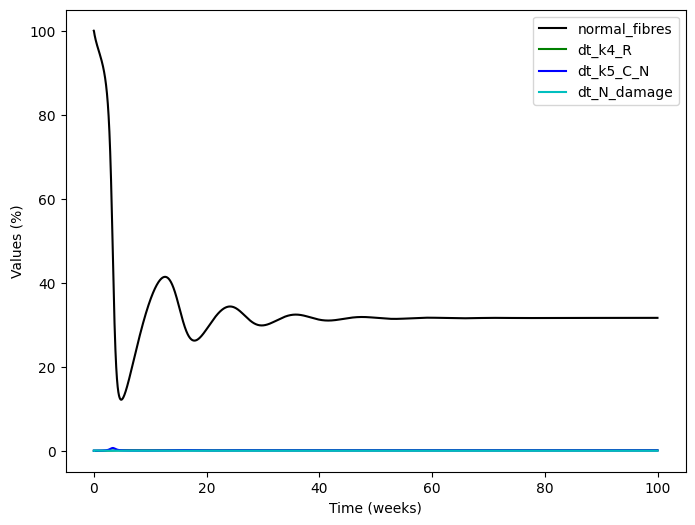

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

if len(Normal) != len(t):
    t.pop()

# Plot each dataset on the same plot with a label for the legend
ax.plot(t, Normal, label='normal_fibres', color='k', linestyle='-')
ax.plot(t, dt_k4_R, label='dt_k4_R', color='g')#, linestyle='--')
ax.plot(t, dt_k5_C_N, label='dt_k5_C_N', color='b')#, linestyle='-.')
ax.plot(t, dt_N_damage, label='dt_N_damage', color='c')#, linestyle=':')

ax.set_xlabel('Time (weeks)')
ax.set_ylabel('Values (%)')

ax.legend(loc='upper right')

#plt.savefig('all_terms_in_N')

# Show the plot
plt.show()

This cell plots the time evolution of the terms that appear in the evolution equation for damaged fibres.

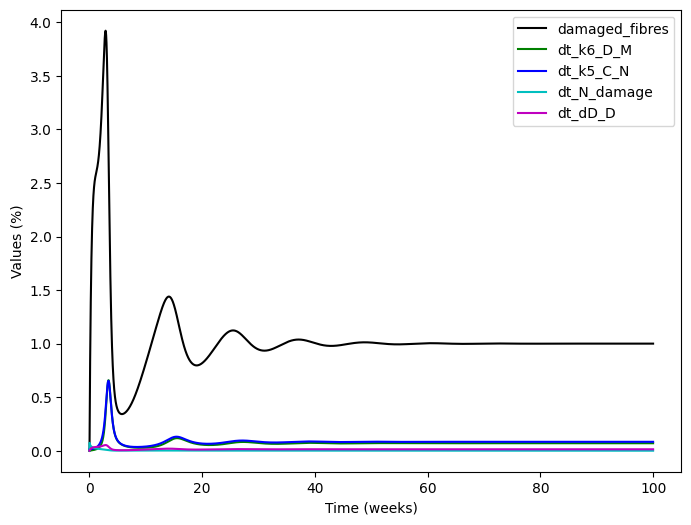

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

if len(Normal) != len(t):
    t.pop()

# Plot each dataset on the same plot with a label for the legend
ax.plot(t, Damaged, label='damaged_fibres', color='k')
ax.plot(t, dt_k6_D_M, label='dt_k6_D_M', color='g')
ax.plot(t, dt_k5_C_N, label='dt_k5_C_N', color='b')
ax.plot(t, dt_N_damage, label='dt_N_damage', color='c')
ax.plot(t, dt_dD_D, label='dt_dD_D', color='m')

ax.set_xlabel('Time (weeks)')
ax.set_ylabel('Values (%)')

ax.legend(loc='upper right')

#plt.savefig('all_terms_in_D')

plt.show()

### Evolution of N and D (alternative implementation)
The second part of this notebook does not require storing the values of each term in the evolution of N and D, so simpler implementations of ev_N and ev_D are provided.

In [17]:
def ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new):
    N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * (k5 * C[i] + damage(t, sigma, m, h)))
    
def ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new):
    D_new[i] = D[i] + dt * (N[i] * (k5 * C[i] + damage(t, sigma, m, h)) - D[i] * (k6 * M[i] + d_D))

### Simulation
This code plots the evolution of both the autonomous and the non-autonomous system from t_min to t_max, comparing it with the value of the stable fixed point. The initialisation is based on the values stored in the variable starting_point. Note that, since this variable is not necessarly equal to the initial conditions i_c extracted from the configuration file, evolving the system from t_min with arbitrary initialisation may not be strictly correct. The system may not be in that specific configuration at t_min. Nonetheless, the code can demonstrate whether a particular configuration converges to a certain fixed point.

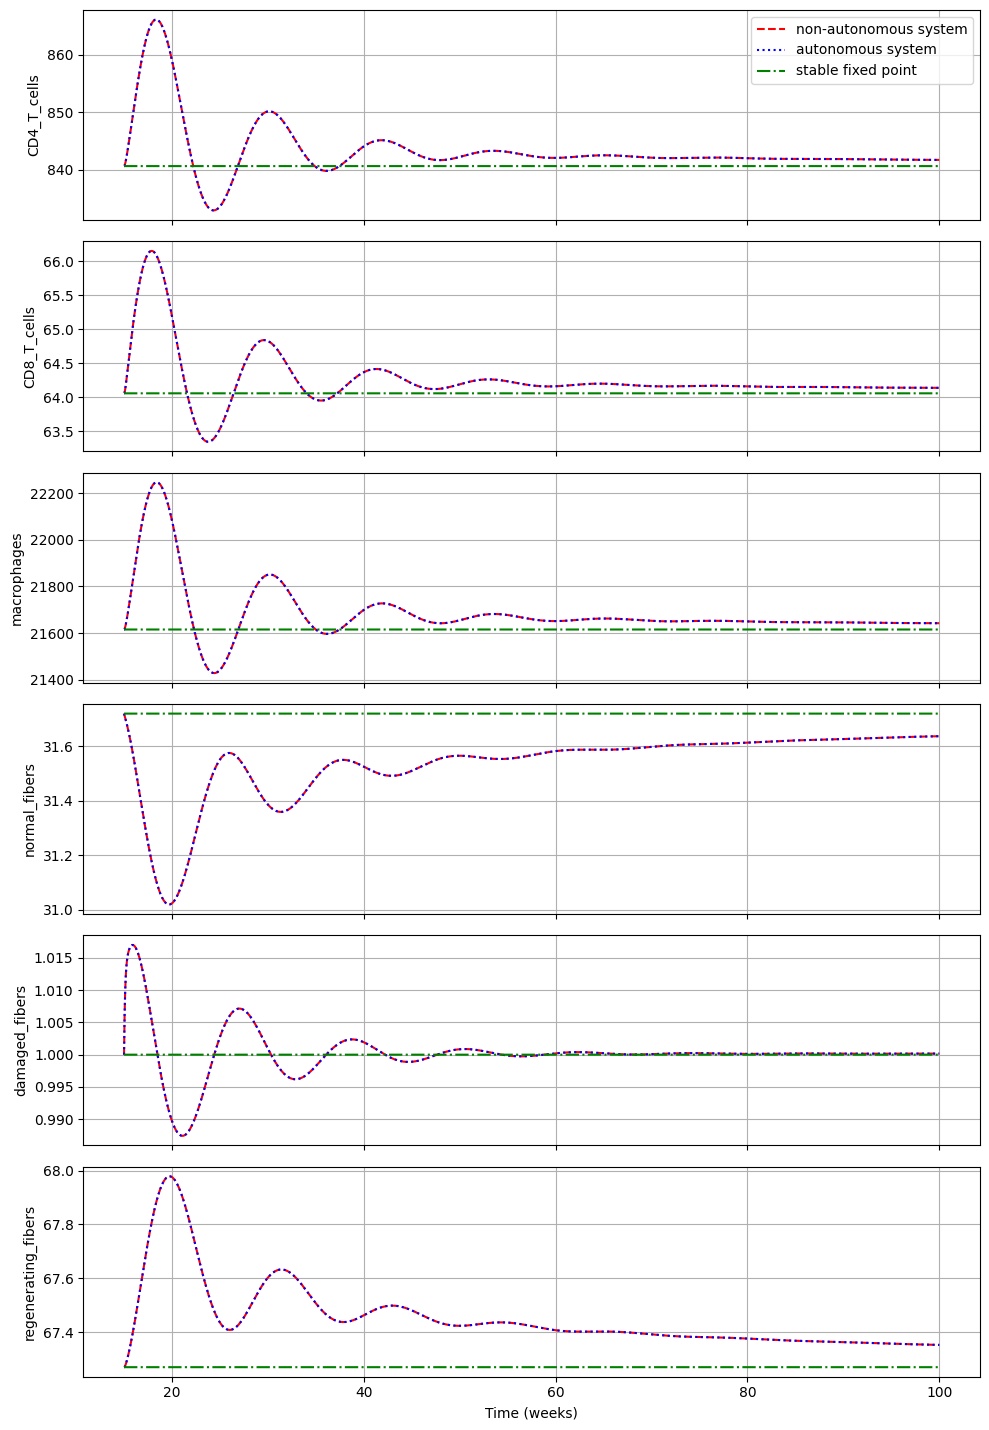

In [19]:
#Evolution over this range of time:
t_min = 15.
t_max = 100.

#starting_point = [30.24, 5.36, 1163.50, 83.62, 0.66, 15.69] #coordinate of the fake fixed point
starting_point = [840.67, 64.06, 21615.10, 31.72, 1.00, 67.27] #coordinate of the fixed point

stable_fp = [840.67, 64.06, 21615.10, 31.72, 1.00, 67.27]

#Simulation for both the autonomous and non-autonomous system
#lists of N_cells values for each state variable 
H, C, M, N, D, R = [[starting_point[i]] * N_cells for i in range(6)]
H_a, C_a, M_a, N_a, D_a, R_a = [[starting_point[i]] * N_cells for i in range(6)]

#list of N_cells values to store the uniform initial conditions
H_i, C_i, M_i, N_i, D_i, R_i = [[i_c[i]] * N_cells for i in range(6)]

#lists of N_cells values for each state variable to store the evolution at each time step
H_new, C_new, M_new, N_new, D_new, R_new = [[starting_point[i]] * N_cells for i in range(6)]
H_a_new, C_a_new, M_a_new, N_a_new, D_a_new, R_a_new = [[starting_point[i]] * N_cells for i in range(6)]

#lists of N_cells values for each state variable, used to store the evolution at each time step.
H_values = [[starting_point[0]] * N_cells]
C_values = [[starting_point[1]] * N_cells]
M_values = [[starting_point[2]] * N_cells]
N_values = [[starting_point[3]] * N_cells]
D_values = [[starting_point[4]] * N_cells]
R_values = [[starting_point[5]] * N_cells]

H_a_values = [[starting_point[0]] * N_cells]
C_a_values = [[starting_point[1]] * N_cells]
M_a_values = [[starting_point[2]] * N_cells]
N_a_values = [[starting_point[3]] * N_cells]
D_a_values = [[starting_point[4]] * N_cells]
R_a_values = [[starting_point[5]] * N_cells]

#Array to store the time steps
t = [t_min]

#Evolution
for j in range(int((t_max - t_min) / dt)):

    one_step(t[j], dt, dx, H, C, M, N, D, R,
             H_new, C_new, M_new, N_new, D_new, R_new,
             H_i, C_i, M_i, par, diffusion, boundary)
    H, C, M, N, D, R = H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()

    one_step_autonomous(dt, dx, H_a, C_a, M_a, N_a, D_a, R_a,
                        H_a_new, C_a_new, M_a_new, N_a_new, D_a_new, R_a_new,
                        H_i, C_i, M_i, par, diffusion, boundary)
    H_a, C_a, M_a, N_a, D_a, R_a = H_a_new.copy(), C_a_new.copy(), M_a_new.copy(), N_a_new.copy(), D_a_new.copy(), R_a_new.copy()

    t.append(round(t[-1] + dt, 2))
    
    H_values.append([float(value) for value in H_new])
    C_values.append([float(value) for value in C_new])
    M_values.append([float(value) for value in M_new])
    N_values.append([float(value) for value in N_new])
    D_values.append([float(value) for value in D_new])
    R_values.append([float(value) for value in R_new])

    H_a_values.append([float(value) for value in H_new])
    C_a_values.append([float(value) for value in C_new])
    M_a_values.append([float(value) for value in M_new])
    N_a_values.append([float(value) for value in N_new])
    D_a_values.append([float(value) for value in D_new])
    R_a_values.append([float(value) for value in R_new])

#Evolution for the non autonomous system in the second cell
column_H_1 = [row[1] for row in H_values]
column_C_1 = [row[1] for row in C_values]
column_M_1 = [row[1] for row in M_values]
column_N_1 = [row[1] for row in N_values]
column_D_1 = [row[1] for row in D_values]
column_R_1 = [row[1] for row in R_values]

#Evolution for the autonomous system in the second cell
column_H_1_a = [row[1] for row in H_a_values]
column_C_1_a = [row[1] for row in C_a_values]
column_M_1_a = [row[1] for row in M_a_values]
column_N_1_a = [row[1] for row in N_a_values]
column_D_1_a = [row[1] for row in D_a_values]
column_R_1_a = [row[1] for row in R_a_values]

#Display the evolution from t_max to t_max_2 for the second cell of the row (representative of the whole system)

cell_1 = [column_H_1, column_C_1, column_M_1, column_N_1, column_D_1, column_R_1]
cell_1_a = [column_H_1_a, column_C_1_a, column_M_1_a, column_N_1_a, column_D_1_a, column_R_1_a]

n_vars = len(cell_1)
labels = ['CD4_T_cells', 'CD8_T_cells', 'macrophages', 'normal_fibers', 'damaged_fibers', 'regenerating_fibers']

fig, axes = plt.subplots(n_vars, 1, figsize=(10, 15), sharex=True)

for i in range(n_vars):
    axes[i].plot(t, cell_1[i], label='non-autonomous system', color='r', linestyle='--')
    axes[i].plot(t, cell_1_a[i], label='autonomous system', color='b', linestyle=':')
    axes[i].plot(t, [stable_fp[i]]*len(t), label='stable fixed point', color='g', linestyle='-.')#, linestyle='dashed')
    axes[i].set_ylabel(labels[i])
    axes[i].grid(True)

axes[-1].set_xlabel('Time (weeks)')
axes[0].legend()

plt.tight_layout()
plt.subplots_adjust(top=0.95)

#plt.savefig('fp1_autonomous_vs_non')

plt.show()